In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import callbacks
from keras import layers, Sequential, callbacks
from keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error
from keras.optimizers.schedules import ExponentialDecay

ImportError: cannot import name 'ExponentialDecay' from 'keras.optimizers.schedules' (c:\Users\bello\miniconda3\envs\comp_vis\lib\site-packages\keras\optimizers\schedules\__init__.py)

# Data Transform

Converts data about the DateTime to a more readable format and also extracts information about the day of the week based on the calendar dates to create new feature.

In [ ]:
data = pd.read_csv("simpletraffic.csv")

data["DateTime"]= pd.to_datetime(data["DateTime"])

data["Year"] = data["DateTime"].dt.year
data["Month"] = data["DateTime"].dt.month
data["Date"] = data["DateTime"].dt.day
data["Hour"] = data["DateTime"].dt.hour
data["DayOfWeek"] = data["DateTime"].dt.dayofweek
data["DayOfWeek"] = data["DayOfWeek"].replace([0,1,2,3,4,5,6],["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

data = data.drop(["ID"], axis=1)

data.head()

,DateTime,Junction,Vehicles,Year,Month,Date,Hour,DayOfWeek
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DateTime   48120 non-null  datetime64[ns]
 1   Junction   48120 non-null  int64         
 2   Vehicles   48120 non-null  int64         
 3   Year       48120 non-null  int64         
 4   Month      48120 non-null  int64         
 5   Date       48120 non-null  int64         
 6   Hour       48120 non-null  int64         
 7   DayOfWeek  48120 non-null  object        
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 2.9+ MB


# Exploratory Data Analysis (EDA)

Text(0.5, 0, 'Date')

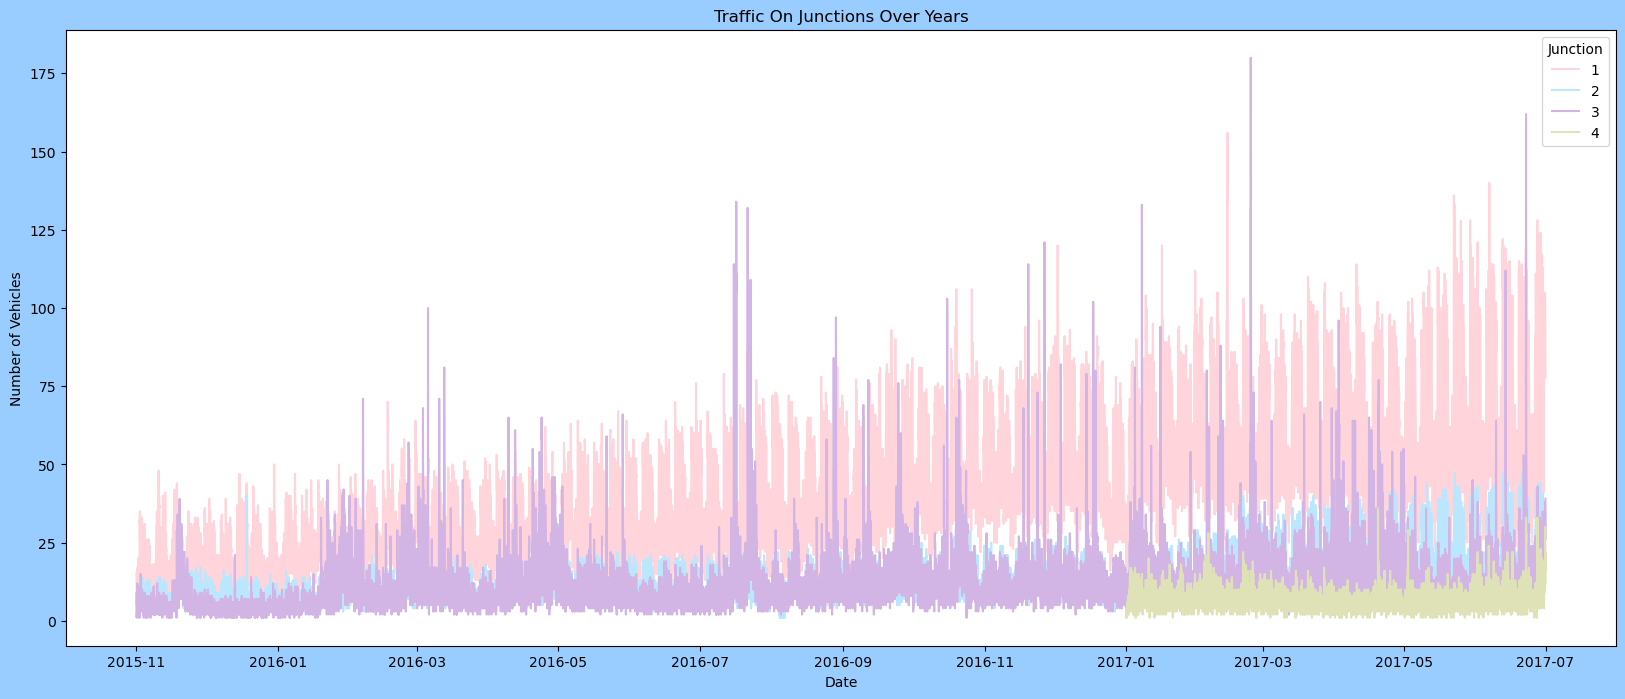

In [ ]:
df=data.copy()
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,8),facecolor="#99ccff")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [ ]:
def make_hist(junction=1):
    data = df[df['Junction'] == junction]
    f, ax = plt.subplots(figsize=(17, 5))
    ax = sns.histplot(data['Vehicles'], kde=True, stat='probability')
    ax.set_title(f'Plot show the distribution of data in junction {junction}')
    ax.grid(True, ls='-.', alpha=0.75)
    plt.show()

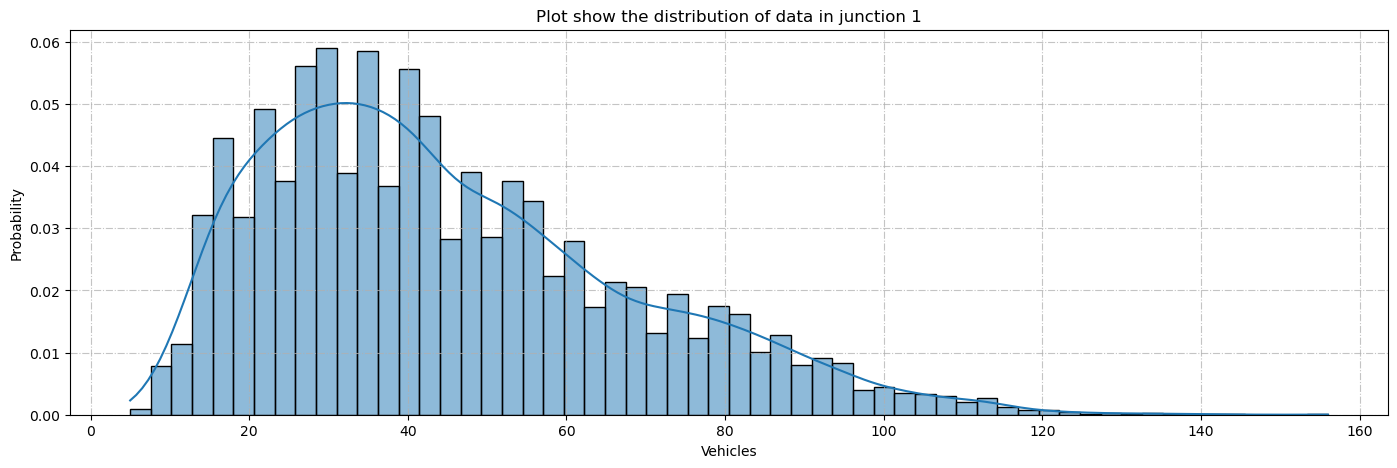

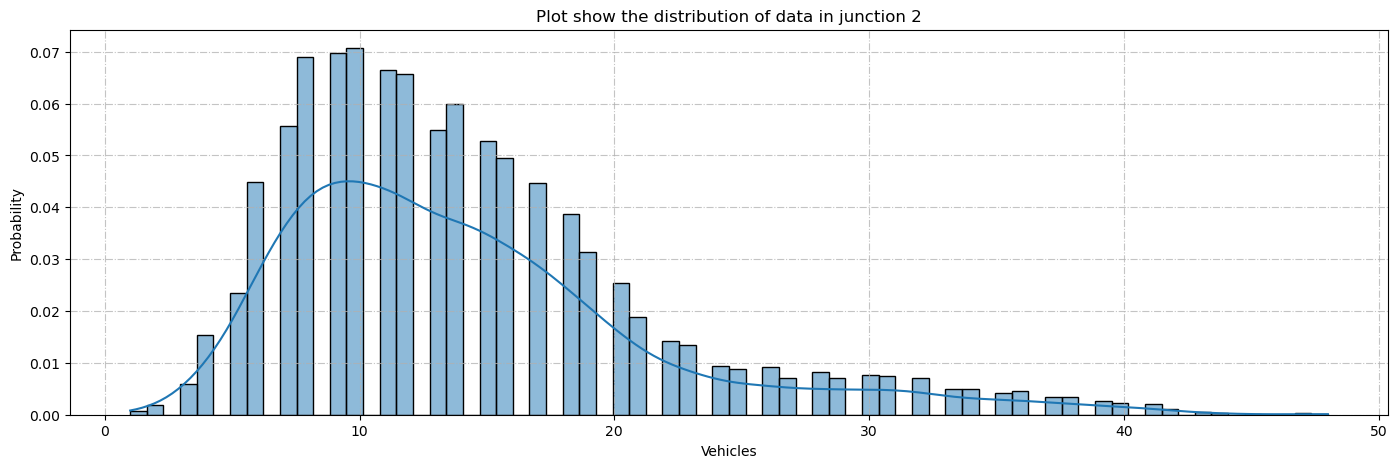

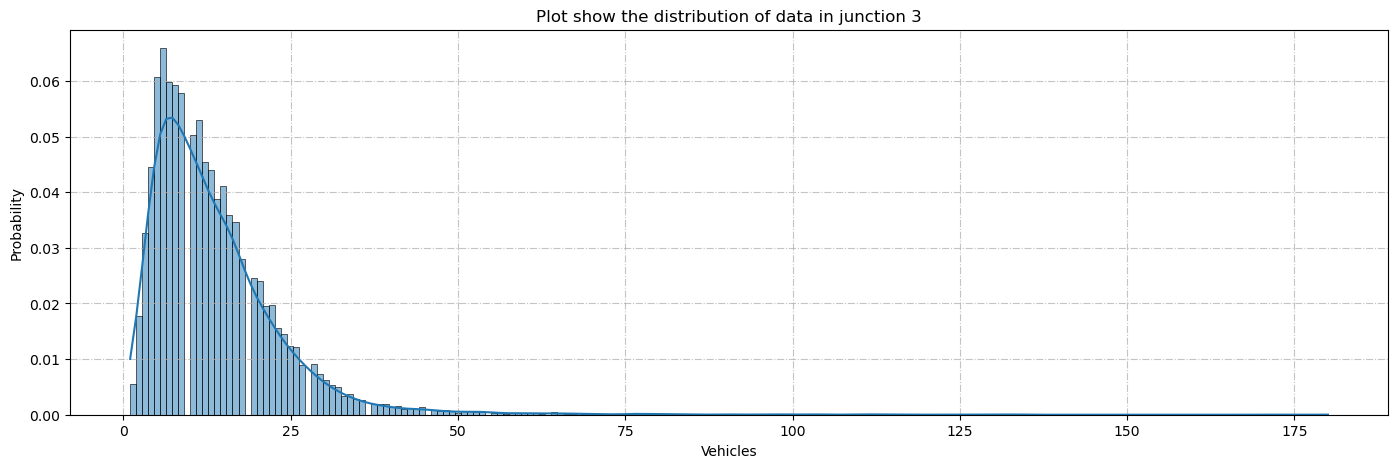

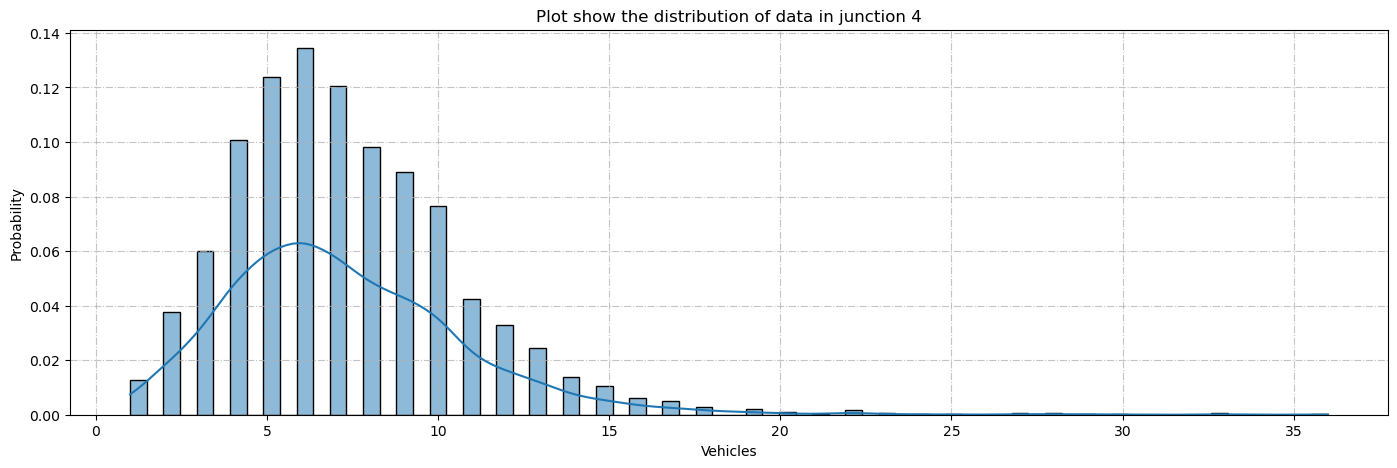

In [ ]:
for jn in range(1, 5):
    make_hist(jn)

Text(0.5, 0, 'Date')

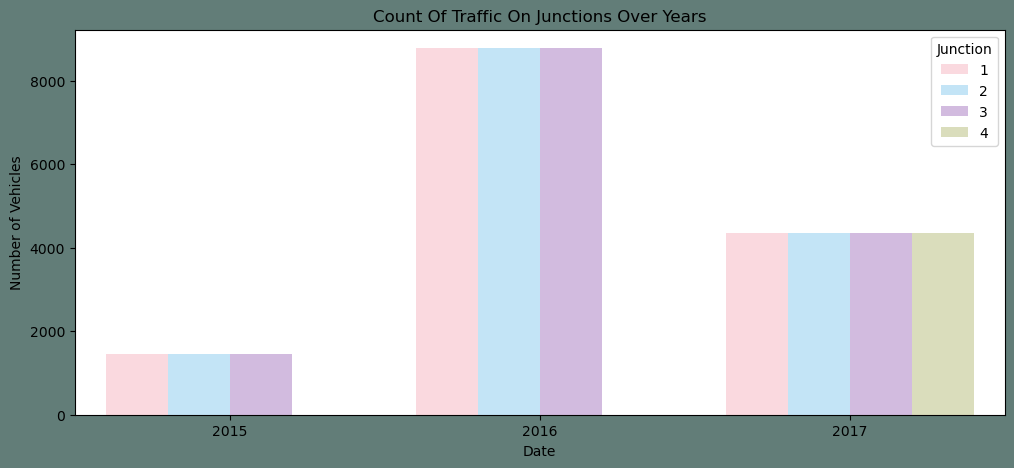

In [ ]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

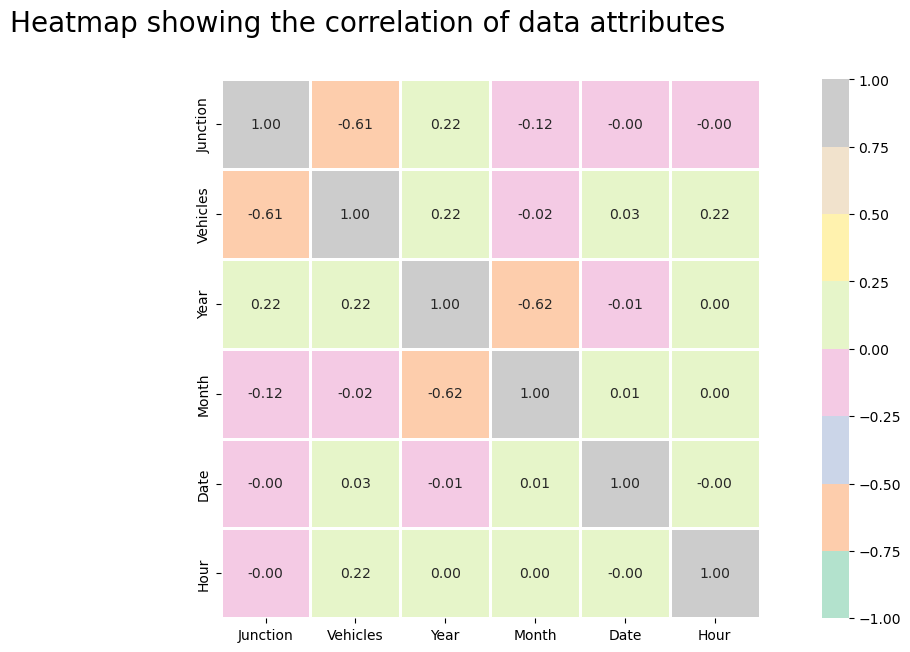

In [ ]:
# Assuming df is your DataFrame
numeric_columns = df.select_dtypes(include='number')
corr = numeric_columns.corr()

# Plotting the heatmap
f, ax = plt.subplots(figsize=(16, 7))
sns.heatmap(corr, cmap= "Pastel2", annot=True, fmt='.2f', vmin=-1, vmax=1, square=True, linewidths=1)
f.suptitle('Heatmap showing the correlation of data attributes', fontsize=20)
plt.show()

In [ ]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

KeyboardInterrupt: 

In [ ]:
def make_metrics(models):
    data = {
        'name': [model.name for model in models[1:]],
        'r2': [model.r2 for model in models[1:]],
        'rmse': [model.rmse for model in models[1:]]
    }
    data['name'] = 'average R2 and sum RMSE'
    data['r2'].append(np.mean(data['r2']))
    data['rmse'].append(np.sum(data['rmse']))
    return pd.DataFrame(data)

# Data Preprocessing

In [ ]:
#Pivoting data fron junction 
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                                   Year  \
Junction             1             2             3            4             1   
count     14592.000000  14592.000000  14592.000000  4344.000000  14592.000000   
mean         45.052906     14.253221     13.694010     7.251611   2016.197368   
std          23.008345      7.401307     10.436005     3.521455      0.599247   
min           5.000000      1.000000      1.000000     1.000000   2015.000000   
25%          27.000000      9.000000      7.000000     5.000000   2016.000000   
50%          40.000000     13.000000     11.000000     7.000000   2016.000000   
75%          59.000000     17.000000     18.000000     9.000000   2017.000000   
max         156.000000     48.000000    180.000000    36.000000   2017.000000   

                                                     Month                \
Junction             2             3       4             1             2   
count     14592.000000  14592.000000  4344.0  14592.000000  14592.000000   
mean       2016.197368   2016.197368  2017.0      6.120066      6.120066   
std           0.599247      0.599247     0.0      3.619842      3.619842   
min        2015.000000   2015.000000  2017.0      1.000000      1.000000   
25%        2016.000000   2016.000000  2017.0      3.000000      3.000000   
50%        2016.000000   2016.000000  2017.0      6.000000      6.000000   
75%        2017.000000   2017.000000  2017.0     10.000000     10.000000   
max        2017.000000   2017.000000  2017.0     12.000000     12.000000   

                                             Date                              \
Junction             3            4             1             2             3   
count     14592.000000  4344.000000  14592.000000  14592.000000  14592.000000   
mean          6.120066     3.508287     15.710526     15.710526     15.710526   
std           3.619842     1.710157      8.789036      8.789036      8.789036   
min           1.000000     1.000000      1.000000      1.000000      1.000000   
25%           3.000000     2.000000      8.000000      8.000000      8.000000   
50%           6.000000     4.000000     16.000000     16.000000     16.000000   
75%          10.000000     5.000000     23.000000     23.000000     23.000000   
max          12.000000     6.000000     31.000000     31.000000     31.000000   

                               Hour                                           
Junction            4             1             2             3            4  
count     4344.000000  14592.000000  14592.000000  14592.000000  4344.000000  
mean        15.602210     11.500000     11.500000     11.500000    11.500000  
std          8.736328      6.922424      6.922424      6.922424     6.922983  
min          1.000000      0.000000      0.000000      0.000000     0.000000  
25%          8.000000      5.750000      5.750000      5.750000     5.750000  
50%         16.000000     11.500000     11.500000     11.500000    11.500000  
75%         23.000000     17.250000     17.250000     17.250000    17.250000  
max         31.000000     23.000000     23.000000     23.000000    23.000000

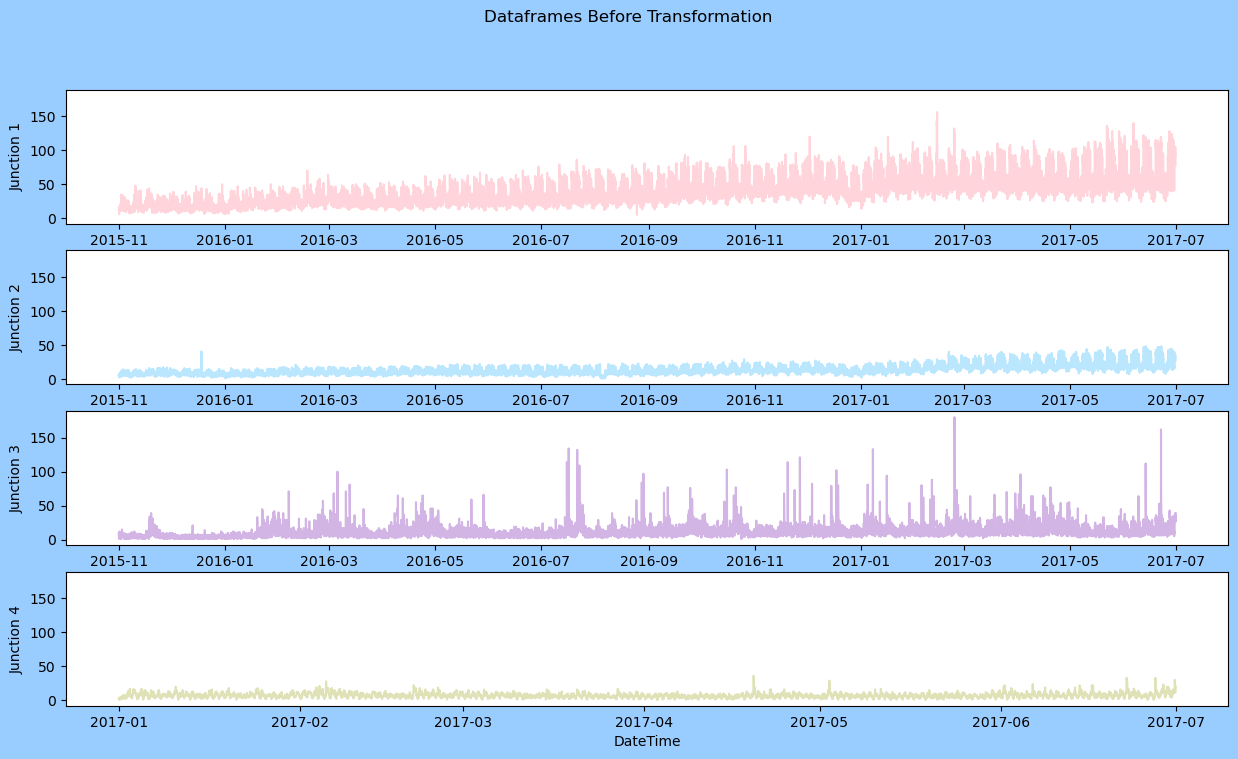

In [ ]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#99ccff", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

A time series attains stationarity when it lacks a discernible trend or seasonality. Nevertheless, during exploratory data analysis (EDA), we observed both a weekly seasonality and an increasing trend over the years. The provided plot reaffirms the ascending trend in Junctions one and two. While narrowing the time span would reveal the weekly seasonality more distinctly, I'll proceed with the corresponding transformations on the datasets.

In [ ]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [ ]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

C:\Users\bello\AppData\Local\Temp\ipykernel_24392\3752011386.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = df[col][i] - df[col][i - interval]
C:\Users\bello\AppData\Local\Temp\ipykernel_24392\3752011386.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = df[col][i] - df[col][i - interval]
C:\Users\bello\AppData\Local\Temp\ipykernel_24392\3752011386.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = 

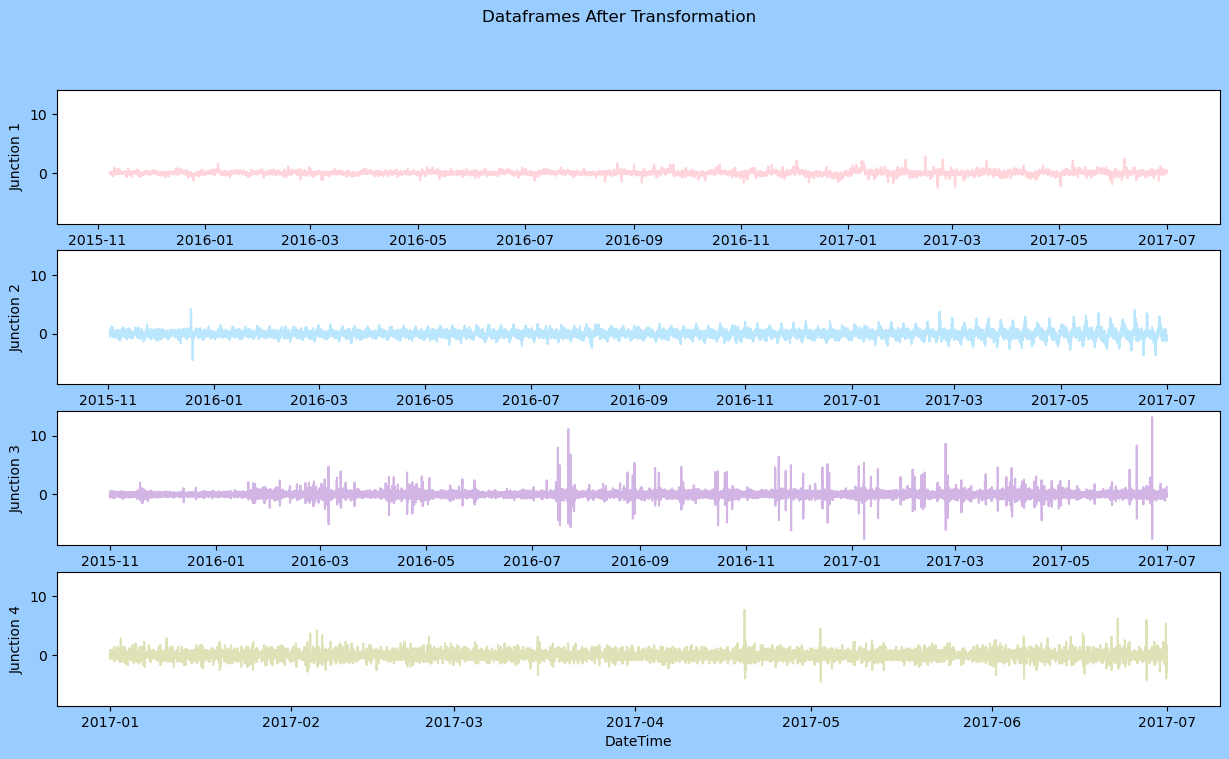

In [ ]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [ ]:
from statsmodels.tsa.stattools import adfuller

#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415449
p-value: 4.798539876396612e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940065
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.00175990883272
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052788
p-value: 2.7787875325943866e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


# Processing data for neural net

In [ ]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y


#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

# Model Building

In [ ]:
# Custom Layer
class CustomLayer(layers.Layer):
    def __init__(self, units=32):
        super(CustomLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

NameError: name 'layers' is not defined

In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

# Custom_Model for the prediction
def Custom_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    model = Sequential()
    model.add(layers.Flatten(input_shape=(X_Train.shape[1], X_Train.shape[2])))  # Flatten layer
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(CustomLayer(50))  # Custom layer
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9), loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120, callbacks=[early_stopping])
    pred_Custom = model.predict(X_Test)
    return pred_Custom

#GRU Model for the prediction
def GRU_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning.
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

# LSTM Model for the prediction
def LSTM_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    
    #The LSTM model 
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_LSTM = model.predict(X_Test)
    return pred_LSTM

# CNN Model for the prediction
def CNN_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    
    #The CNN model 
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_Train.shape[1],1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(units=1))
    
    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_CNN = model.predict(X_Test)
    return pred_CNN

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#99ccff")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

# Model Fitting

In [ ]:
#Predictions For First Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ1_Custom = Custom_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ1_GRU = GRU_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ1_LSTM = LSTM_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ1_CNN = CNN_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

In [ ]:
# Results for J1 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J1_Custom = RMSE_Value(y_testJ1, PredJ1_Custom)
PredictionsPlot(y_testJ1, PredJ1_Custom, 0)

# Results for J1 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J1_GRU = RMSE_Value(y_testJ1, PredJ1_GRU)
PredictionsPlot(y_testJ1, PredJ1_GRU, 0)

# Results for J1 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J1_LSTM = RMSE_Value(y_testJ1, PredJ1_LSTM)
PredictionsPlot(y_testJ1, PredJ1_LSTM, 0)

# Results for J1 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J1_CNN = RMSE_Value(y_testJ1, PredJ1_CNN)
PredictionsPlot(y_testJ1, PredJ1_CNN, 0)

In [ ]:
# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J1_Custom, RMSE_J1_GRU, RMSE_J1_LSTM, RMSE_J1_CNN]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")   

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_1 = model_names[best_model_index]
best_model_rmse_1 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_1, best_model_rmse_1))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.9
fig, ax = plt.subplots(figsize=(10, 4))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J1')
plt.show()

display(styled_df)

In [ ]:
# Predictions For Second Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ2_Custom = Custom_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ2_GRU = GRU_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ2_LSTM = LSTM_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ2_CNN = CNN_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

In [ ]:
# Results for J2 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J2_Custom = RMSE_Value(y_testJ2, PredJ2_Custom)
PredictionsPlot(y_testJ2, PredJ2_Custom, 0)

# Results for J2 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J2_GRU = RMSE_Value(y_testJ2, PredJ2_GRU)
PredictionsPlot(y_testJ2, PredJ2_GRU, 0)

# Results for J2 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J2_LSTM = RMSE_Value(y_testJ2, PredJ2_LSTM)
PredictionsPlot(y_testJ2, PredJ2_LSTM, 0)

# Results for J2 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J2_CNN = RMSE_Value(y_testJ2, PredJ2_CNN)
PredictionsPlot(y_testJ2, PredJ2_CNN, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J2_Custom, RMSE_J2_GRU, RMSE_J2_LSTM, RMSE_J2_CNN]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")   

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_2 = model_names[best_model_index]
best_model_rmse_2 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_2, best_model_rmse_2))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J2')
plt.show()

display(styled_df)

In [ ]:
# Predictions For Third Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ3_Custom = Custom_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ3_GRU = GRU_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ3_LSTM = LSTM_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ3_CNN = CNN_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)

In [ ]:
# Results for J3 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J3_Custom = RMSE_Value(y_testJ3, PredJ3_Custom)
PredictionsPlot(y_testJ3, PredJ3_Custom, 0)

# Results for J3 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J3_GRU = RMSE_Value(y_testJ3, PredJ3_GRU)
PredictionsPlot(y_testJ3, PredJ3_GRU, 0)

# Results for J3 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J3_LSTM = RMSE_Value(y_testJ3, PredJ3_LSTM)
PredictionsPlot(y_testJ3, PredJ3_LSTM, 0)

# Results for J3 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J3_CNN = RMSE_Value(y_testJ3, PredJ3_CNN)
PredictionsPlot(y_testJ3, PredJ3_CNN, 0)


# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J3_Custom, RMSE_J3_GRU, RMSE_J3_LSTM, RMSE_J3_CNN]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")   

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_3 = model_names[best_model_index]
best_model_rmse_3 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_3, best_model_rmse_3))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J3')
plt.show()

display(styled_df)

In [ ]:
# Predictions For Fourth Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ4_Custom = Custom_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ4_GRU = GRU_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ4_LSTM = LSTM_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ4_CNN = CNN_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)

In [ ]:
# Results for J4 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J4_Custom = RMSE_Value(y_testJ4, PredJ4_Custom)
PredictionsPlot(y_testJ4, PredJ4_Custom, 0)

# Results for J4 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J4_GRU = RMSE_Value(y_testJ4, PredJ4_GRU)
PredictionsPlot(y_testJ4, PredJ4_GRU, 0)

# Results for J4 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J4_LSTM = RMSE_Value(y_testJ4, PredJ4_LSTM)
PredictionsPlot(y_testJ4, PredJ4_LSTM, 0)

# Results for J4 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J4_CNN = RMSE_Value(y_testJ4, PredJ4_CNN)
PredictionsPlot(y_testJ4, PredJ4_CNN, 0)


# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J4_Custom, RMSE_J4_GRU, RMSE_J4_LSTM, RMSE_J4_CNN]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")   

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_4 = model_names[best_model_index]
best_model_rmse_4 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_4, best_model_rmse_4))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J4')
plt.show()

display(styled_df)

In [ ]:
#Initialise data of lists for error values of four junctions.
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [best_model_rmse_1, best_model_rmse_2, best_model_rmse_3, best_model_rmse_4]
Model = [best_model_name_1, best_model_name_2, best_model_name_3, best_model_name_4]
list_of_tuples = list(zip(Junctions, RMSE, Model))
# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE", "MODEL"])
Results.style.background_gradient(cmap="Pastel1")   